In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
import csv
import re
import pandas as pd
import numpy as np

import pandas
import os

from reconchess import GameHistory
import matplotlib.pyplot as plt
from tqdm import tqdm

### Find approximate quantiles

In [40]:
data_path = "../game_logs/ranked_games"

wins = []
losses = []

for batch in os.listdir(data_path):
    for game_id in tqdm(os.listdir(os.path.join(data_path, batch))):
        try:
            game = GameHistory.from_file(os.path.join(data_path, batch, game_id, f"game_{game_id}.log"))
            has_won = (game.get_white_player_name() == "Zubat") == game.get_winner_color()
            game_log = os.path.join(data_path, batch, game_id, f"move_scores_{game_id}.csv")
            df = pd.read_csv(game_log)
            mx = df.groupby("move_number").max()
            if has_won:
                wins.append(mx["analytical"].to_list())
            else:
                losses.append(mx["analytical"].to_list())
        except:
            pass

100%|██████████| 100/100 [00:00<00:00, 200.40it/s]


In [41]:
len(wins), len(losses)

(435, 158)

In [42]:
res = np.array([x for win in wins for x in win] + [x for loss in losses for x in loss] * 3)
len(res)

30317

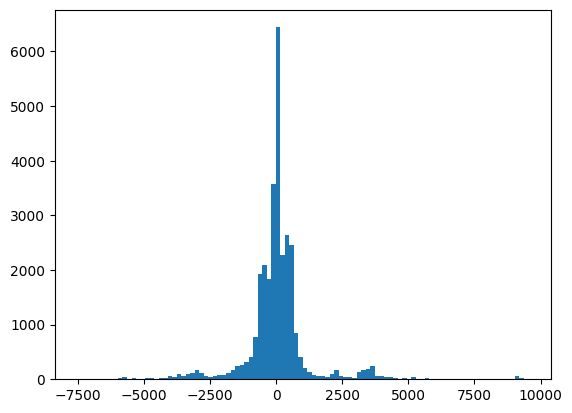

In [43]:
plt.hist(res, bins=100)
plt.show()

In [44]:
len(res[res >= 0]), len(res[res < 0])

(16503, 13814)

In [45]:
pd.qcut(res[res >= 0], 2), pd.qcut(res[res < 0], 2)

([(0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427], ..., (0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427], (0.0359, 352.427]]
 Length: 16503
 Categories (2, interval[float64, right]): [(0.0359, 352.427] < (352.427, 9538.0]],
 [(-423.002, -0.0204], (-423.002, -0.0204], (-423.002, -0.0204], (-423.002, -0.0204], (-423.002, -0.0204], ..., (-7519.336, -423.002], (-7519.336, -423.002], (-7519.336, -423.002], (-7519.336, -423.002], (-7519.336, -423.002]]
 Length: 13814
 Categories (2, interval[float64, right]): [(-7519.336, -423.002] < (-423.002, -0.0204]])

In [52]:
len(res[res < -400]), len(res[(res < 0) & (res >= -400)]), len(res[(res < 400) & (res >= 0)]), len(res[res >= 400])

(7166, 6648, 8923, 7580)

Ranges will be (-inf, -400), (-400, 0), (0, 400), (400, inf)

### Calculating

In [165]:
categories = [-400, 0, 400]
result_thresholds = [-50, 50]
risky_move_threshold = 50

In [166]:
results = pd.DataFrame(
    {"category": [
        f"(-inf, {categories[0]})", 
        f"({categories[0]}, {categories[1]})", 
        f"({categories[1]}, {categories[2]})", 
        f"({categories[2]}, inf)"
    ][::-1], 
     "positive": [0, 0, 0, 0], "neutral": [0, 0, 0, 0], "negative": [0, 0, 0, 0]})

In [167]:
data_path = "../game_logs/ranked_games"
for batch in os.listdir(data_path):
    for game_id in tqdm(os.listdir(os.path.join(data_path, batch))):
        try:
            game = GameHistory.from_file(os.path.join(data_path, batch, game_id, f"game_{game_id}.log"))
            game_log = os.path.join(data_path, batch, game_id, f"move_scores_{game_id}.csv")
            df = pd.read_csv(game_log)
            
            gr_df = df.groupby("move_number")
            risky_moves = np.where(gr_df["analytical"].max() - gr_df.first()["analytical"] > risky_move_threshold)[0] + 1
            risky_moves
            
            analytical_scores = gr_df.max()["analytical"]
            for move in risky_moves:
                category = np.digitize(analytical_scores[move], categories)
                if move < len(gr_df):
                    result = np.digitize(analytical_scores[move] - analytical_scores[move+1], result_thresholds)
                    results.iloc[3-category, result+1] += 1
                else:
                    result = 2 * (game.get_white_player_name() == "Zubat") == game.get_winner_color()
                    results.iloc[3-category, result+1] += 1
        except:
            pass

100%|██████████| 100/100 [00:00<00:00, 155.76it/s]


In [168]:
results

,category,positive,neutral,negative
0,"(400, inf)",323,341,295
1,"(0, 400)",148,141,226
2,"(-400, 0)",93,77,180
3,"(-inf, -400)",97,39,133


In [169]:
results2 = results.copy()
results2["positive"] = results["positive"] / (results["positive"] + results["neutral"] + results["negative"])
results2["neutral"] = results["neutral"] / (results["positive"] + results["neutral"] + results["negative"])
results2["negative"] = results["negative"] / (results["positive"] + results["neutral"] + results["negative"])
results2

,category,positive,neutral,negative
0,"(400, inf)",0.336809,0.355579,0.307612
1,"(0, 400)",0.287379,0.273786,0.438835
2,"(-400, 0)",0.265714,0.220000,0.514286
3,"(-inf, -400)",0.360595,0.144981,0.494424


In [172]:
results.to_csv("results.csv")
results2.to_csv("results_percentage.csv")